# 1. Load required Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# 2. Load the DataFrame

In [2]:
df = pd.read_excel("production_confirmations.xlsx", sheet_name = "MES_confirmations")
df.head()

,Production Order Number,Final Confirmation,Cancellation,Entered by User,Operation,Confirmed Yield,Confirmed Scrap,Unit,Operation Name
0,PO_3420,1,NaN,Prod_Worker_33,10,160,1,PC,Cutting 1
1,PO_3421,0,NaN,Prod_Worker_65,10,150,11,PC,Cutting 1
2,PO_3421,1,NaN,Prod_Worker_91,10,13,13,PC,Cutting 1
3,PO_3421,0,NaN,Prod_Worker_65,20,142,0,PC,Cutting 2
4,PO_3421,1,NaN,Prod_Worker_91,20,9,12,PC,Cutting 2


# 3. Understanding the DataSet and Data Wrangling

In [3]:
df.columns

Index(['Production Order Number', 'Final Confirmation', 'Cancellation',
       'Entered by User', 'Operation', 'Confirmed Yield', 'Confirmed Scrap',
       'Unit', 'Operation Name'],
      dtype='object')

In [4]:
df.shape

(1121, 9)

In [5]:
df.dtypes

Production Order Number    object
Final Confirmation          int64
Cancellation               object
Entered by User            object
Operation                   int64
Confirmed Yield             int64
Confirmed Scrap             int64
Unit                       object
Operation Name             object
dtype: object

In [6]:
# rename columns:
df.rename(columns = {"Production Order Number" : "ProductionOrderNr", 
                     "Operation" : "OperationID", 
                     "Operation Name" : "OperationName", 
                     "Confirmed Yield" : "ConfirmedYield", 
                     "Confirmed Scrap" : "ConfirmedScrap", 
                     "Entered by User" : "EnteredByUser", 
                     "Final Confirmation" : "FinalConfirmation"}, inplace = True)

# reorder the columns to give the dataset a better overview
column_order = ["ProductionOrderNr", "OperationID", "OperationName", "ConfirmedYield", "ConfirmedScrap", "Unit", "Cancellation", "EnteredByUser", "FinalConfirmation"]
df = df[column_order]
df

,ProductionOrderNr,OperationID,OperationName,ConfirmedYield,ConfirmedScrap,Unit,Cancellation,EnteredByUser,FinalConfirmation
0,PO_3420,10,Cutting 1,160,1,PC,NaN,Prod_Worker_33,1
1,PO_3421,10,Cutting 1,150,11,PC,NaN,Prod_Worker_65,0
2,PO_3421,10,Cutting 1,13,13,PC,NaN,Prod_Worker_91,1
3,PO_3421,20,Cutting 2,142,0,PC,NaN,Prod_Worker_65,0
4,PO_3421,20,Cutting 2,9,12,PC,NaN,Prod_Worker_91,1
...,...,...,...,...,...,...,...,...,...
1116,PO_3471,40,Welding,103,4,PC,NaN,Prod_Worker_91,0
1117,PO_3471,40,Welding,89,3,PC,NaN,Prod_Worker_91,0
1118,PO_3471,40,Welding,202,1,PC,NaN,Prod_Worker_91,1
1119,PO_3471,60,Heat Treatment,353,23,PC,NaN,Prod_Worker_91,0


In [7]:
# Clean the data from the wrong confirmations (=> ConfirmedYield, ConfirmedScrap < 0) by summing up the confirmed yield and scrap amounts, as well as the final confirmations
df_finished_POs = df.groupby(["ProductionOrderNr", "OperationID"]).agg({'ConfirmedYield' : 'sum', 
                                                                        'ConfirmedScrap' : 'sum', 
                                                                        'FinalConfirmation' : 'sum'}).reset_index()
df_finished_POs

,ProductionOrderNr,OperationID,ConfirmedYield,ConfirmedScrap,FinalConfirmation
0,PO_3420,10,160,1,1
1,PO_3421,10,163,24,1
2,PO_3421,20,151,12,1
3,PO_3422,10,143,8,1
4,PO_3422,20,148,3,1
...,...,...,...,...,...
501,PO_3471,10,500,0,1
502,PO_3471,20,500,0,1
503,PO_3471,30,495,5,1
504,PO_3471,40,487,8,1


In [8]:
# Find all the orders that are not finalized yet (orders which has the sum of all final confirmations per operation smaller than 1)
notfinal = list(df_finished_POs.loc[df_finished_POs['FinalConfirmation'] < 1].ProductionOrderNr.unique())
notfinal

['PO_3423', 'PO_3444', 'PO_3458', 'PO_3469', 'PO_3470']

In [9]:
# Filter out the unfinished POs 
df_finished_POs = df_finished_POs.loc[~df_finished_POs["ProductionOrderNr"].isin(notfinal)]
df_finished_POs

,ProductionOrderNr,OperationID,ConfirmedYield,ConfirmedScrap,FinalConfirmation
0,PO_3420,10,160,1,1
1,PO_3421,10,163,24,1
2,PO_3421,20,151,12,1
3,PO_3422,10,143,8,1
4,PO_3422,20,148,3,1
...,...,...,...,...,...
501,PO_3471,10,500,0,1
502,PO_3471,20,500,0,1
503,PO_3471,30,495,5,1
504,PO_3471,40,487,8,1


## 3.1. Remove the unfinished Orders

In [10]:
# unfinished orders are the ones who have their last Operation ID < 150
unfinished = df_finished_POs.groupby("ProductionOrderNr")["OperationID"].max()
unfinished = unfinished.where(unfinished < 150).dropna().index.values
unfinished

array(['PO_3420', 'PO_3421', 'PO_3422', 'PO_3424', 'PO_3425', 'PO_3426',
       'PO_3427', 'PO_3428', 'PO_3429', 'PO_3430', 'PO_3431', 'PO_3432',
       'PO_3433', 'PO_3434', 'PO_3435', 'PO_3436', 'PO_3437', 'PO_3438',
       'PO_3471'], dtype=object)

In [11]:
df_finished_POs = df_finished_POs.loc[~df_finished_POs.ProductionOrderNr.isin(unfinished)]
df_finished_POs

,ProductionOrderNr,OperationID,ConfirmedYield,ConfirmedScrap,FinalConfirmation
64,PO_3439,10,240,0,1
65,PO_3439,20,233,7,1
66,PO_3439,30,233,0,1
67,PO_3439,40,232,1,1
68,PO_3439,50,229,3,1
...,...,...,...,...,...
468,PO_3468,140,290,34,1
469,PO_3468,145,273,17,1
470,PO_3468,150,264,9,1
471,PO_3468,155,225,39,1


In [12]:
df_finished_POs = df_finished_POs.copy()
# add the column Process Amount (Process Amount = Confirmed Yield + Confirmed Scrap)
df_finished_POs["ProcessAmount"] = df_finished_POs["ConfirmedYield"] + df_finished_POs["ConfirmedScrap"]
# reorder columns 
cols = list(df_finished_POs.columns.values)
df_finished_POs = df_finished_POs[cols[0:2] + [cols[5]] + cols[2:5]]
df_finished_POs

,ProductionOrderNr,OperationID,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation
64,PO_3439,10,240,240,0,1
65,PO_3439,20,240,233,7,1
66,PO_3439,30,233,233,0,1
67,PO_3439,40,233,232,1,1
68,PO_3439,50,232,229,3,1
...,...,...,...,...,...,...
468,PO_3468,140,324,290,34,1
469,PO_3468,145,290,273,17,1
470,PO_3468,150,273,264,9,1
471,PO_3468,155,264,225,39,1


## 3.2. Add the Operational Yield

In [13]:
df_finished_POs = df_finished_POs.copy()

# Add the Operational Yield column 
# Operational Yield = ConfirmedYield / (ConfirmedYield + ConfirmedScrap)
df_finished_POs["OperationalYield"] = df_finished_POs["ConfirmedYield"] / (df_finished_POs["ProcessAmount"])
df_finished_POs

,ProductionOrderNr,OperationID,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation,OperationalYield
64,PO_3439,10,240,240,0,1,1.000000
65,PO_3439,20,240,233,7,1,0.970833
66,PO_3439,30,233,233,0,1,1.000000
67,PO_3439,40,233,232,1,1,0.995708
68,PO_3439,50,232,229,3,1,0.987069
...,...,...,...,...,...,...,...
468,PO_3468,140,324,290,34,1,0.895062
469,PO_3468,145,290,273,17,1,0.941379
470,PO_3468,150,273,264,9,1,0.967033
471,PO_3468,155,264,225,39,1,0.852273


## 3.3. Add the Cumulative Yield

In [14]:
df_finished_POs = df_finished_POs.copy()

df_finished_POs.set_index(["ProductionOrderNr", "OperationID"], inplace = True)
df_finished_POs["CumulativeYield"] = df_finished_POs.groupby("ProductionOrderNr")["OperationalYield"].cumprod()
df_finished_POs.reset_index(inplace = True)
df_finished_POs

,ProductionOrderNr,OperationID,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation,OperationalYield,CumulativeYield
0,PO_3439,10,240,240,0,1,1.000000,1.000000
1,PO_3439,20,240,233,7,1,0.970833,0.970833
2,PO_3439,30,233,233,0,1,1.000000,0.970833
3,PO_3439,40,233,232,1,1,0.995708,0.966667
4,PO_3439,50,232,229,3,1,0.987069,0.954167
...,...,...,...,...,...,...,...,...
383,PO_3468,140,324,290,34,1,0.895062,0.580000
384,PO_3468,145,290,273,17,1,0.941379,0.546000
385,PO_3468,150,273,264,9,1,0.967033,0.528000
386,PO_3468,155,264,225,39,1,0.852273,0.450000


## 3.4. Add the Shipping Dates to the DataFrame

In [15]:
df_dates = pd.read_excel("production_confirmations.xlsx", sheet_name = "ShippingDates")
df_dates = df_dates.rename(columns = {"Production Order Number" : "ProductionOrderNr", 
                           "Shipping Date" : "ShippingDate"})
df_dates

,ProductionOrderNr,ShippingDate,Executor
0,PO_3407,2022-03-24,Logistics
1,PO_3408,2022-03-31,Logistics
2,PO_3409,2022-04-07,Logistics
3,PO_3410,2022-04-14,Logistics
4,PO_3411,2022-04-21,Logistics
...,...,...,...
58,PO_3467,2023-05-04,Logistics
59,PO_3468,2023-05-11,Logistics
60,PO_3469,2023-05-18,Logistics
61,PO_3470,2023-05-25,Logistics


In [16]:
# merge the shipping date to the DataFrame
df_finished_POs = df_finished_POs.merge(df_dates[["ProductionOrderNr", "ShippingDate"]], on = "ProductionOrderNr", how = "left")

In [17]:
# map the OperationName to the df_finished_POs DataFrame
op_id_name = df[["OperationID", "OperationName"]].copy()
op_id_name = op_id_name.drop_duplicates(keep = "first", ignore_index= True)

df_finished_POs = df_finished_POs.merge(op_id_name, on = "OperationID", how = "left")
df_finished_POs

,ProductionOrderNr,OperationID,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation,OperationalYield,CumulativeYield,ShippingDate,OperationName
0,PO_3439,10,240,240,0,1,1.000000,1.000000,2022-11-03,Cutting 1
1,PO_3439,20,240,233,7,1,0.970833,0.970833,2022-11-03,Cutting 2
2,PO_3439,30,233,233,0,1,1.000000,0.970833,2022-11-03,Bending 1
3,PO_3439,40,233,232,1,1,0.995708,0.966667,2022-11-03,Welding
4,PO_3439,50,232,229,3,1,0.987069,0.954167,2022-11-03,Bending 2
...,...,...,...,...,...,...,...,...,...,...
383,PO_3468,140,324,290,34,1,0.895062,0.580000,2023-05-11,QA Test 3
384,PO_3468,145,290,273,17,1,0.941379,0.546000,2023-05-11,Plasma Treatment 2
385,PO_3468,150,273,264,9,1,0.967033,0.528000,2023-05-11,BG 4 ASM
386,PO_3468,155,264,225,39,1,0.852273,0.450000,2023-05-11,Optical Inspection 2


In [18]:
# reorder columns 
cols = list(df_finished_POs.columns.values)
df_finished_POs = df_finished_POs.copy()[cols[:2] + [cols[8]] + cols [2:8]]
df_finished_POs         

,ProductionOrderNr,OperationID,ShippingDate,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation,OperationalYield,CumulativeYield
0,PO_3439,10,2022-11-03,240,240,0,1,1.000000,1.000000
1,PO_3439,20,2022-11-03,240,233,7,1,0.970833,0.970833
2,PO_3439,30,2022-11-03,233,233,0,1,1.000000,0.970833
3,PO_3439,40,2022-11-03,233,232,1,1,0.995708,0.966667
4,PO_3439,50,2022-11-03,232,229,3,1,0.987069,0.954167
...,...,...,...,...,...,...,...,...,...
383,PO_3468,140,2023-05-11,324,290,34,1,0.895062,0.580000
384,PO_3468,145,2023-05-11,290,273,17,1,0.941379,0.546000
385,PO_3468,150,2023-05-11,273,264,9,1,0.967033,0.528000
386,PO_3468,155,2023-05-11,264,225,39,1,0.852273,0.450000


In [19]:
df_finished_POs.dtypes

ProductionOrderNr            object
OperationID                   int64
ShippingDate         datetime64[ns]
ProcessAmount                 int64
ConfirmedYield                int64
ConfirmedScrap                int64
FinalConfirmation             int64
OperationalYield            float64
CumulativeYield             float64
dtype: object

In [20]:
df_finished_POs.isna().any()

ProductionOrderNr    False
OperationID          False
ShippingDate         False
ProcessAmount        False
ConfirmedYield       False
ConfirmedScrap       False
FinalConfirmation    False
OperationalYield     False
CumulativeYield      False
dtype: bool

In [21]:
# introduce the month and year as separate columns
df_finished_POs.loc[:, "Month"] = df_finished_POs["ShippingDate"].dt.month
df_finished_POs.loc[:, "Year"] = df_finished_POs["ShippingDate"].dt.year

df_finished_POs

,ProductionOrderNr,OperationID,ShippingDate,ProcessAmount,ConfirmedYield,ConfirmedScrap,FinalConfirmation,OperationalYield,CumulativeYield,Month,Year
0,PO_3439,10,2022-11-03,240,240,0,1,1.000000,1.000000,11,2022
1,PO_3439,20,2022-11-03,240,233,7,1,0.970833,0.970833,11,2022
2,PO_3439,30,2022-11-03,233,233,0,1,1.000000,0.970833,11,2022
3,PO_3439,40,2022-11-03,233,232,1,1,0.995708,0.966667,11,2022
4,PO_3439,50,2022-11-03,232,229,3,1,0.987069,0.954167,11,2022
...,...,...,...,...,...,...,...,...,...,...,...
383,PO_3468,140,2023-05-11,324,290,34,1,0.895062,0.580000,5,2023
384,PO_3468,145,2023-05-11,290,273,17,1,0.941379,0.546000,5,2023
385,PO_3468,150,2023-05-11,273,264,9,1,0.967033,0.528000,5,2023
386,PO_3468,155,2023-05-11,264,225,39,1,0.852273,0.450000,5,2023


In [22]:
df_finished_POs.dtypes

ProductionOrderNr            object
OperationID                   int64
ShippingDate         datetime64[ns]
ProcessAmount                 int64
ConfirmedYield                int64
ConfirmedScrap                int64
FinalConfirmation             int64
OperationalYield            float64
CumulativeYield             float64
Month                         int64
Year                          int64
dtype: object

# 4. Plotting the Data

In [23]:
def print_po_to_plot(df_finished_POs):
    orders_to_plot = list(df_finished_POs.ProductionOrderNr.unique())
    print("The orders that can be ploted are:\n")
    counter = 0
    for i in orders_to_plot: 
        counter += 1
        print(i, end = "    ")
        if counter % 3 == 0:
            print("")
    print(f"\nThe amount of orders that can be ploted is {len(orders_to_plot)}.")
    return orders_to_plot

orders_to_plot = print_po_to_plot(df_finished_POs)

The orders that can be ploted are:

PO_3439    PO_3440    PO_3441    
PO_3442    PO_3443    PO_3445    
PO_3446    PO_3447    PO_3448    
PO_3449    PO_3450    PO_3451    
PO_3452    PO_3453    PO_3454    
PO_3455    PO_3456    PO_3459    
PO_3460    PO_3461    PO_3462    
PO_3463    PO_3464    PO_3465    
PO_3466    PO_3467    PO_3468    

The amount of orders that can be ploted is 27.


## 4.1. Operational Yield Barplot

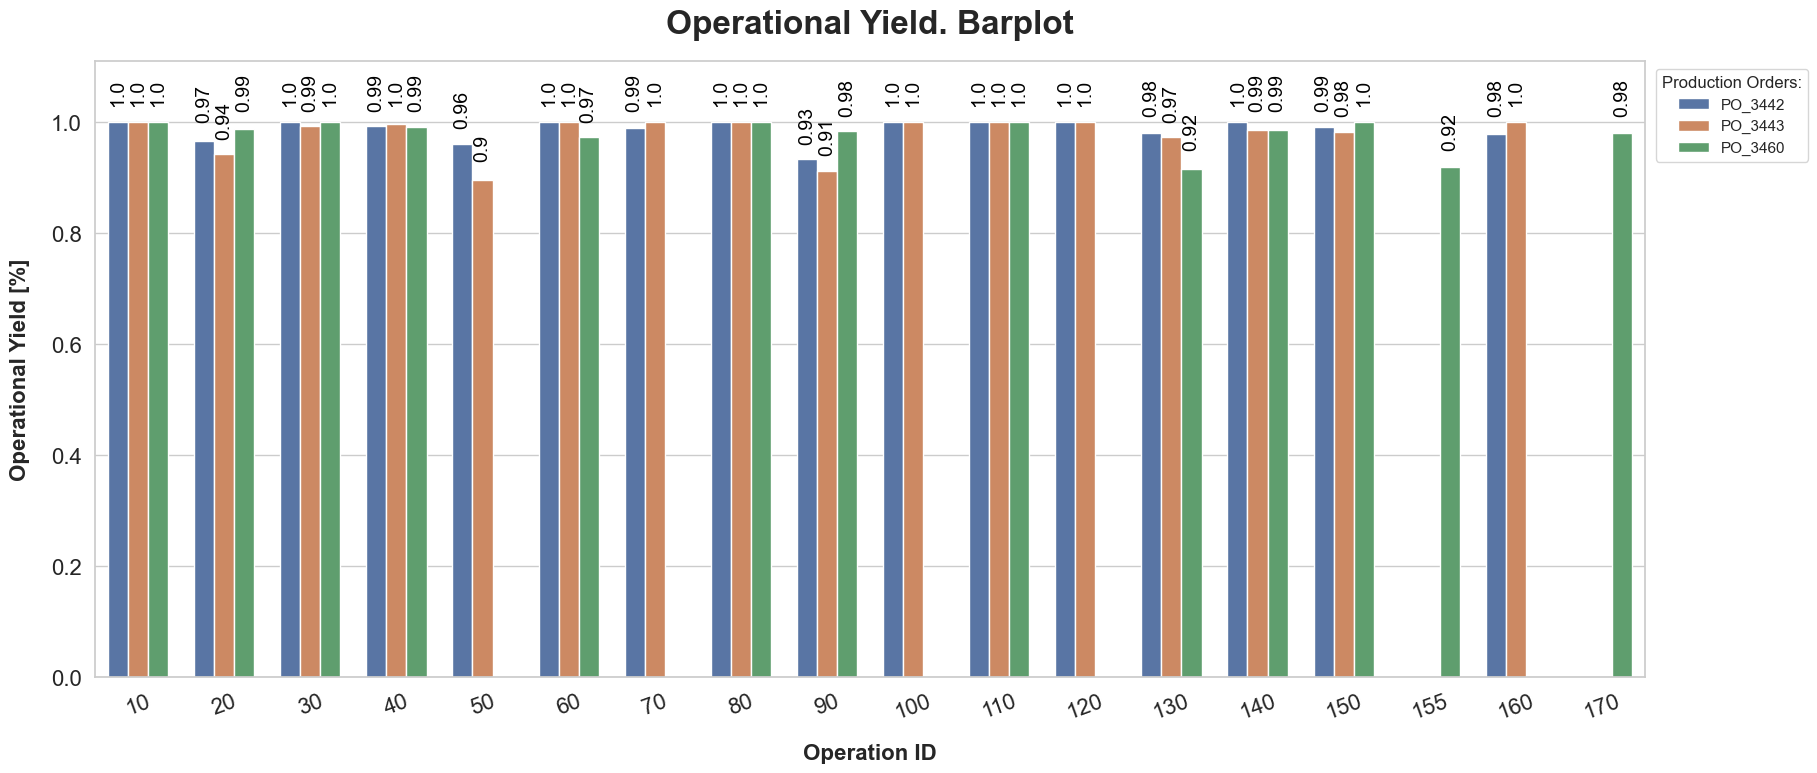

In [24]:
plt.figure(figsize=(20, 8))
sns.set_theme(style="whitegrid")


ax = sns.barplot(data = df_finished_POs.loc[df_finished_POs.ProductionOrderNr.isin(list(orders_to_plot[i] for i in [3,4,18]))], 
                 x = "OperationID", 
                 y = "OperationalYield", 
                 hue = "ProductionOrderNr", 
                 width = .7)
plt.title("Operational Yield. Barplot", fontsize = 24, fontweight = "bold", pad = 20)
plt.xlabel("Operation ID", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.ylabel("Operational Yield [%]", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.ylim([0, 1.11])
plt.xticks(rotation = 20, fontsize = 16)
plt.yticks(fontsize = 16)

# adding the annotations to the bars: 
for p in ax.patches:
    width = p.get_width()
    height = np.round(p.get_height(), decimals = 2)
    x, y = p.get_xy() 
    ax.annotate('{}'.format(height), 
                (x + width/2, y + height),
                xytext = (0, 12),
                textcoords = 'offset points',
                ha='center', 
                va = 'bottom',
                rotation = 90, 
                color = 'black',
                fontsize = 14)
plt.legend(title = "Production Orders:", loc='best', bbox_to_anchor=(0.61, 0.5, 0.5, 0.5))
plt.show()

## 4.2. Cumulative Yield Barplot

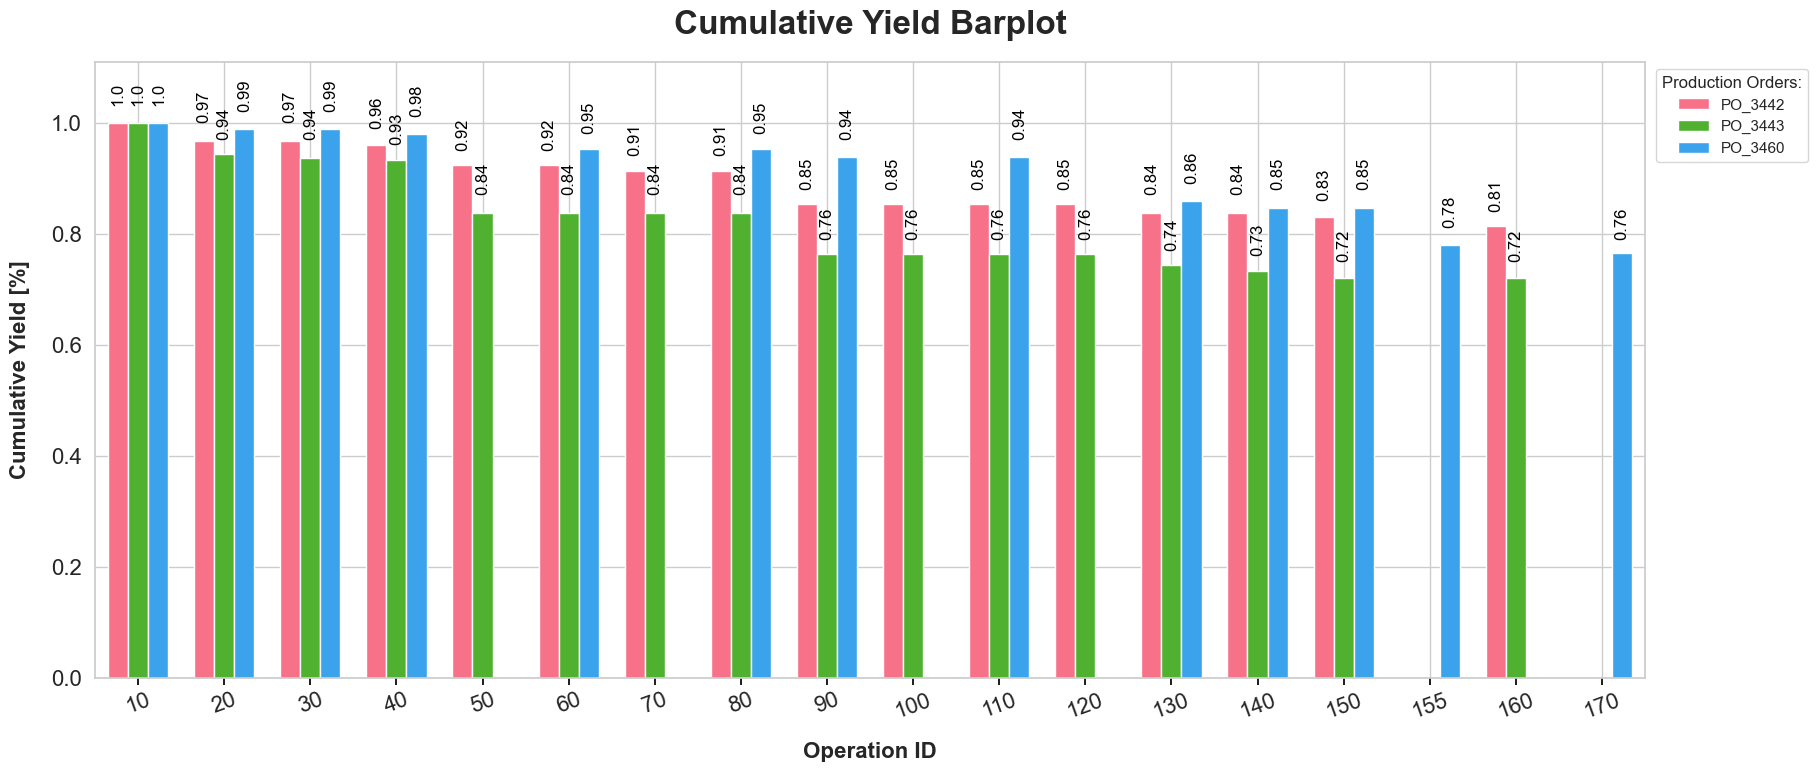

In [25]:
plt.figure(figsize=(20, 8))

ax = sns.barplot(data = df_finished_POs.loc[df_finished_POs.ProductionOrderNr.isin(list(orders_to_plot[i] for i in [3,4,18]))], 
                 x = "OperationID", 
                 y = "CumulativeYield", 
                 hue = "ProductionOrderNr",
                 width = .7,
                 palette = "husl",
                 saturation = 1)
plt.title("Cumulative Yield Barplot", fontsize = 24, fontweight = "bold", pad = 20)
plt.xlabel("Operation ID", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.ylabel("Cumulative Yield [%]", fontsize = 16, fontweight = "bold", labelpad = 15)

plt.tick_params(axis = "x", 
                bottom = True, 
                top = False, 
                direction = "out", 
                length = 5, 
                color = "black", 
                reset = True)


plt.ylim([0, 1.11])
plt.xticks(rotation = 20, fontsize = 16)
plt.yticks(fontsize = 16)

# adding the annotations to the bars: 
for p in ax.patches:
    width = p.get_width()
    height = np.round(p.get_height(), decimals = 2)
    x, y = p.get_xy() 
    ax.annotate('{}'.format(height), 
               (x + width/2, y + height),
               xytext = (0, 12),
               textcoords = 'offset points',
               ha='center', 
               va = 'bottom',
               rotation = 90, 
               color = 'black',
               fontsize = 12)

plt.legend(title = "Production Orders:", loc='best', bbox_to_anchor=(0.61, 0.5, 0.5, 0.5))

plt.show()

## 4.3. Material Flow Chart

In [26]:
print_po_to_plot(df_finished_POs)

The orders that can be ploted are:

PO_3439    PO_3440    PO_3441    
PO_3442    PO_3443    PO_3445    
PO_3446    PO_3447    PO_3448    
PO_3449    PO_3450    PO_3451    
PO_3452    PO_3453    PO_3454    
PO_3455    PO_3456    PO_3459    
PO_3460    PO_3461    PO_3462    
PO_3463    PO_3464    PO_3465    
PO_3466    PO_3467    PO_3468    

The amount of orders that can be ploted is 27.


['PO_3439',
 'PO_3440',
 'PO_3441',
 'PO_3442',
 'PO_3443',
 'PO_3445',
 'PO_3446',
 'PO_3447',
 'PO_3448',
 'PO_3449',
 'PO_3450',
 'PO_3451',
 'PO_3452',
 'PO_3453',
 'PO_3454',
 'PO_3455',
 'PO_3456',
 'PO_3459',
 'PO_3460',
 'PO_3461',
 'PO_3462',
 'PO_3463',
 'PO_3464',
 'PO_3465',
 'PO_3466',
 'PO_3467',
 'PO_3468']

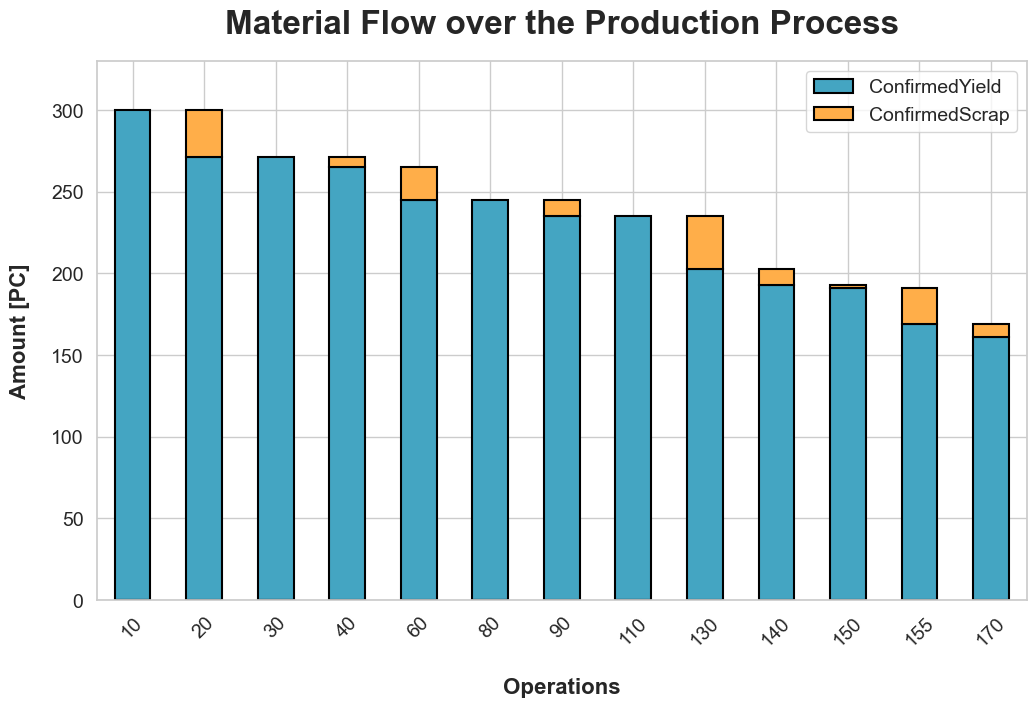

In [27]:
# establish the material flow dataframe mat_flow_df. The order number can be adjusted to inverstigate other ones.
mat_flow_df = df_finished_POs.loc[df_finished_POs.ProductionOrderNr == "PO_3459"][["ProductionOrderNr", "OperationID", "ConfirmedYield", "ConfirmedScrap"]].copy()

mat_flow_df.plot(kind = 'bar', 
                 stacked = True, 
                 x = "OperationID", 
                 y = ["ConfirmedYield", "ConfirmedScrap"], 
                 color = ["#44a5c2", "#ffae49"],
                 edgecolor = "black", 
                 linewidth = 1.5,
                 figsize = (12, 7))
plt.title("Material Flow over the Production Process", fontsize = 24, fontweight = "bold", pad = 20)
plt.xlabel("Operations", fontsize = 16, fontweight = "bold", labelpad = 20)
plt.ylabel('Amount [PC]', fontsize = 16, fontweight = "bold", labelpad = 15)
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([0, mat_flow_df.ConfirmedYield.max() + 30])
plt.legend(loc = "best", fontsize = 14)
plt.show()

## 4.4. Investigate the Correlation between Starting Amount and FPY (First Pass Yield)

In [28]:
starting_amounts = df_finished_POs.loc[df_finished_POs.OperationID == 10].copy()
starting_amounts["StartingAmount"] = starting_amounts["ConfirmedYield"] + starting_amounts["ConfirmedScrap"]
starting_amounts = starting_amounts[["ProductionOrderNr", "StartingAmount"]].reset_index(drop = True)
starting_amounts

,ProductionOrderNr,StartingAmount
0,PO_3439,240
1,PO_3440,300
2,PO_3441,300
3,PO_3442,300
4,PO_3443,300
5,PO_3445,281
6,PO_3446,340
7,PO_3447,240
8,PO_3448,300
9,PO_3449,300


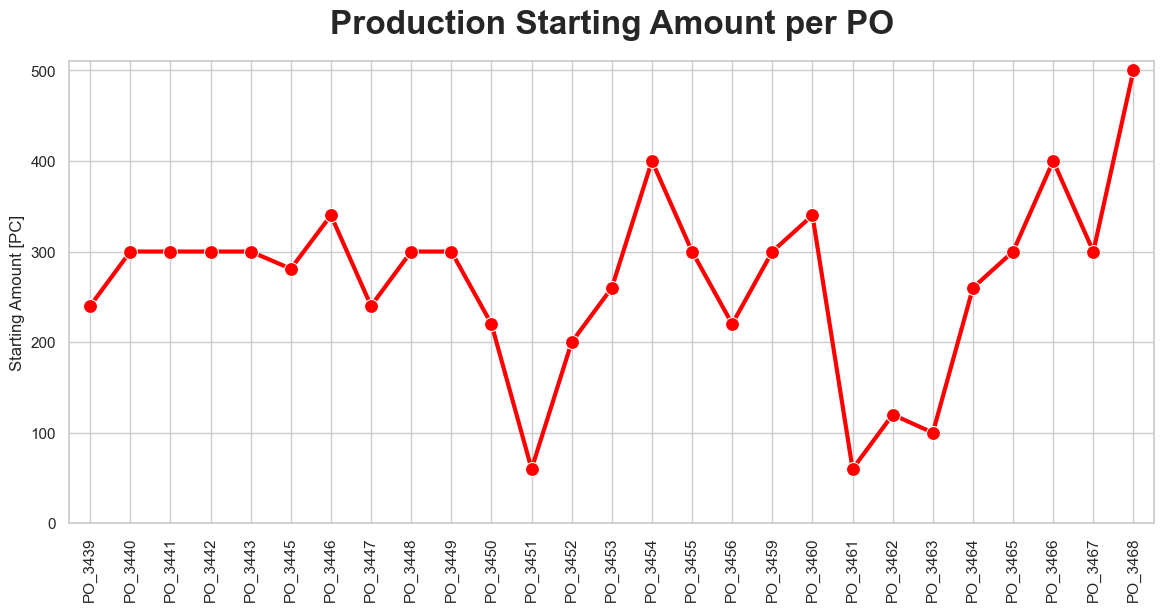

In [29]:
# Check the distribution of the starting amounts of each Production run
plt.figure(figsize=(14, 6))
sns.lineplot(data = starting_amounts, x = "ProductionOrderNr", y = "StartingAmount", marker = "o", markersize = 10, linewidth = 3, color = "red")
plt.title("Production Starting Amount per PO", fontsize = 24, fontweight = "bold", pad = 20)
plt.xlabel("")
plt.ylabel("Starting Amount [PC]")
plt.xticks(rotation = 90)
plt.ylim([0, 510])
plt.margins(x = .02)
plt.show()

In [30]:
df_fpy = df_finished_POs.groupby("ProductionOrderNr")["OperationID"].max().to_frame().reset_index()
df_fpy = df_fpy.merge(df_finished_POs, 
                      left_on = ["ProductionOrderNr", "OperationID"], 
                      right_on = ["ProductionOrderNr", "OperationID"], 
                      how = "left")[["ProductionOrderNr", "OperationID", "ConfirmedYield", "CumulativeYield"]].rename(columns = {"OperationID" : "LastOperationID", 
                                                                                                                                 "ConfirmedYield" : "OutputAmount", 
                                                                                                                                 "CumulativeYield" : "PO_overall_Yield"})
df_fpy = df_fpy.merge(starting_amounts, 
                      left_on = ["ProductionOrderNr"], 
                      right_on = ["ProductionOrderNr"], 
                      how = "left")
df_fpy = df_fpy[["ProductionOrderNr", "StartingAmount", "OutputAmount", "PO_overall_Yield"]]
df_fpy

,ProductionOrderNr,StartingAmount,OutputAmount,PO_overall_Yield
0,PO_3439,240,151,0.629167
1,PO_3440,300,192,0.640000
2,PO_3441,300,210,0.700000
3,PO_3442,300,244,0.813333
4,PO_3443,300,216,0.720000
5,PO_3445,281,159,0.565836
6,PO_3446,340,202,0.594118
7,PO_3447,240,208,0.866667
8,PO_3448,300,241,0.803333
9,PO_3449,300,126,0.420000


,StartingAmount,OutputAmount,PO_overall_Yield
StartingAmount,1.000000,0.769129,-0.384838
OutputAmount,0.769129,1.000000,0.258615
PO_overall_Yield,-0.384838,0.258615,1.000000


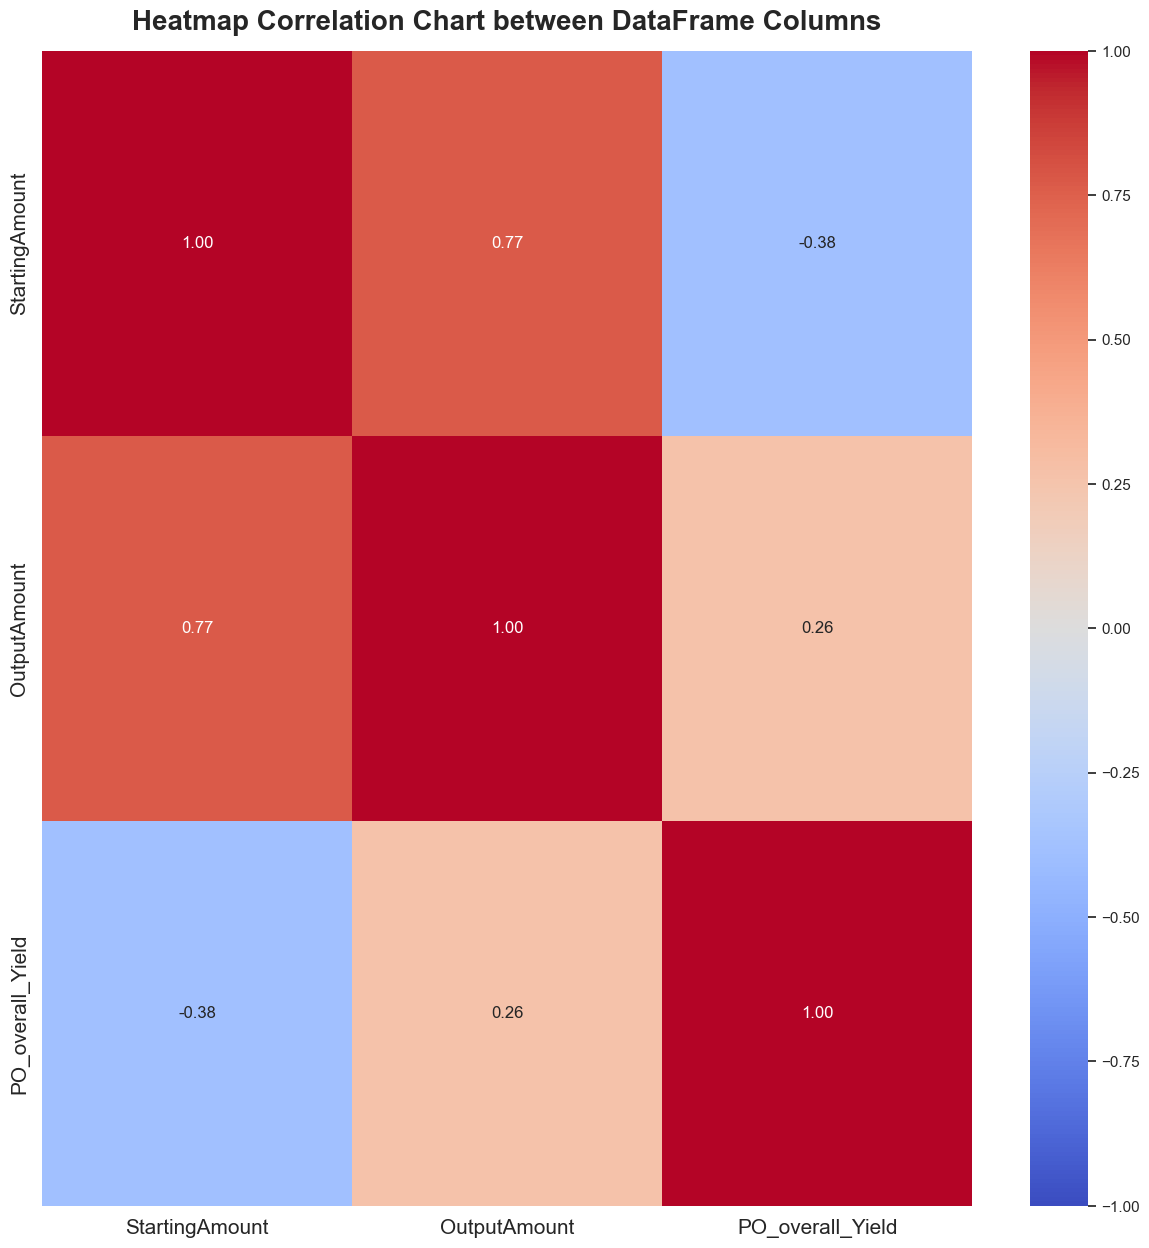

In [31]:
# Investigate the correlation between the Starting Amount and the Overall Yield:
display(df_fpy.corr(numeric_only = True))

plt.figure(figsize=(15,15))
sns.heatmap(df_fpy.corr(numeric_only = True),
            annot=True, 
            fmt = ".2f",
            vmin = -1,
            vmax = 1,
            cmap = "coolwarm")
plt.title("Heatmap Correlation Chart between DataFrame Columns", fontsize = 20, fontweight = "bold", pad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

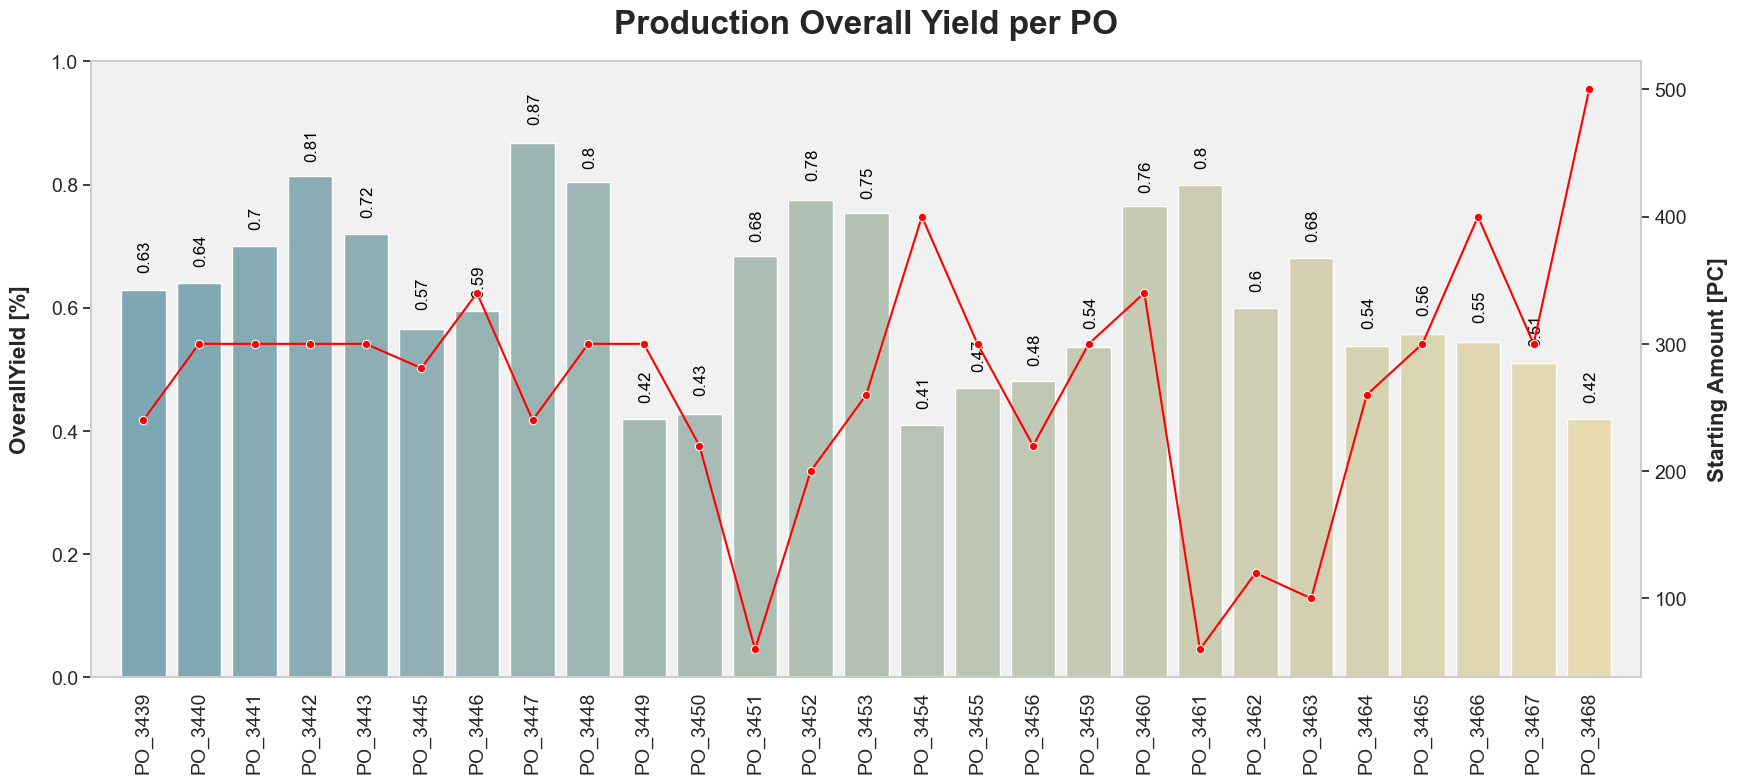

In [32]:
# Plot the Overall Yields of the POs together with the 
fig, ax1 = plt.subplots(figsize=(20, 8))
ax1 = sns.barplot(data = df_fpy, x = "ProductionOrderNr", y = "PO_overall_Yield", palette = "blend:#7AB,#EDA", saturation = 0.8)
ax1.set_facecolor('#F1F1F1')
plt.ylim([0, 1])
plt.ylabel("OverallYield [%]", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.xlabel("")
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 14)
plt.margins(x = .02)
plt.grid(visible = False)
# adding the annotations to the bars: 
for p in ax1.patches:
    width = p.get_width()
    height = np.round(p.get_height(), decimals = 2)
    x, y = p.get_xy() 
    ax1.annotate('{}'.format(height), 
               (x + width/2 + .03, y + height),
               xytext = (0, 12),
               textcoords = 'offset points',
               ha='center', 
               va = 'bottom',
               rotation = 90, 
               color = 'black',
               fontsize = 12)

ax2 = ax1.twinx()
ax2 = sns.lineplot(data = starting_amounts, x = "ProductionOrderNr", y = "StartingAmount", marker = "o", color = "red")
plt.title("Production Overall Yield per PO", fontsize = 24, fontweight = "bold", pad = 20)
plt.xlabel("")
plt.ylabel("Starting Amount [PC]", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.xticks(ticks = None)
plt.yticks(fontsize = 14)
plt.margins(x = .02)

plt.grid(visible = False)
plt.show()

## 4.5. Investigate the AVG Opearational Yield per Month

In [33]:
df_avg_plot = df_finished_POs.copy()
df_avg_plot = df_avg_plot.groupby(["Year", "Month", "OperationID"]).agg({"OperationalYield" : "mean", "ProductionOrderNr" : lambda x: list(x)}).rename(columns = {"OperationalYield" : "AVG_OperationalYield", "ProductionOrderNr" : "ProductionOrderNrList"})
df_avg_plot = df_avg_plot.reset_index()
df_avg_plot

,Year,Month,OperationID,AVG_OperationalYield,ProductionOrderNrList
0,2022,11,10,1.000000,"[PO_3439, PO_3440, PO_3441, PO_3442]"
1,2022,11,20,0.948542,"[PO_3439, PO_3440, PO_3441, PO_3442]"
2,2022,11,30,0.994643,"[PO_3439, PO_3440, PO_3441, PO_3442]"
3,2022,11,40,0.992671,"[PO_3439, PO_3440, PO_3441, PO_3442]"
4,2022,11,50,0.944074,"[PO_3439, PO_3440, PO_3441, PO_3442]"
...,...,...,...,...,...
100,2023,5,140,0.916281,"[PO_3467, PO_3468]"
101,2023,5,145,0.923467,"[PO_3467, PO_3468]"
102,2023,5,150,0.974314,"[PO_3467, PO_3468]"
103,2023,5,155,0.904261,"[PO_3467, PO_3468]"


In [34]:
df_avg_plot.groupby("OperationID").agg({"Year" : lambda x: list(x), 
                                       "Month" : lambda x: list(x),
                                       "AVG_OperationalYield" : "mean"})

,Year,Month,AVG_OperationalYield
OperationID,,,
10,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.999873
20,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.953357
30,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.995162
40,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.976959
50,"[2022, 2022, 2023, 2023]","[11, 12, 1, 2]",0.942908
60,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.951396
70,"[2022, 2022, 2023]","[11, 12, 1]",0.994911
80,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.999846
90,"[2022, 2022, 2023, 2023, 2023, 2023, 2023]","[11, 12, 1, 2, 3, 4, 5]",0.933233


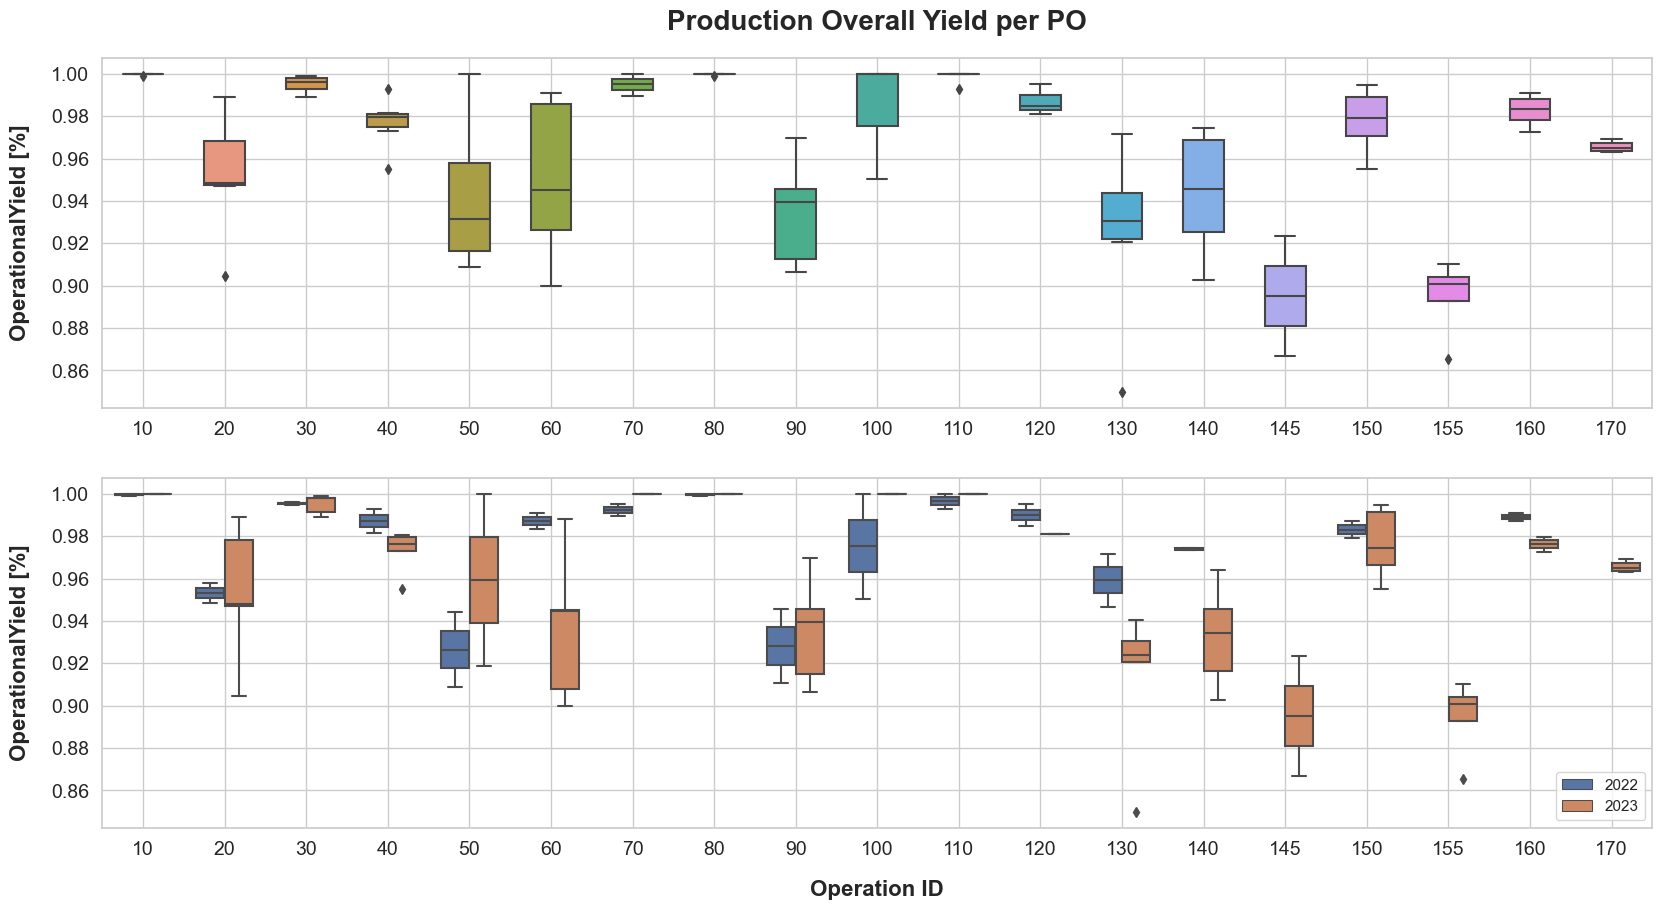

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
sns.boxplot(data = df_avg_plot, 
            x = "OperationID",
            y = "AVG_OperationalYield", 
            width = 0.5)
plt.title("Production Overall Yield per PO", fontsize = 20, fontweight = "bold", pad = 20)
plt.xlabel("")
plt.ylabel("OperationalYield [%]", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(axis = "both", visible = True)


plt.subplot(2, 1, 2)
sns.boxplot(data = df_avg_plot, 
            x = "OperationID",
            y = "AVG_OperationalYield", width = 0.7,
            hue = "Year")
plt.title("")
plt.xlabel("Operation ID", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.ylabel("OperationalYield [%]", fontsize = 16, fontweight = "bold", labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(axis = "both", visible = True)
plt.legend(loc = "lower right")

plt.subplots_adjust(hspace = .2)